In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model



figsize = (11,6)
legend_fontsize = 16

print('Setup is done!')

Setup is done!


# 1 Data preparation

Loading data:

In [2]:
datapath = 'covid-data.csv'

df = pd.read_csv(datapath)
df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Convert strings containing date and time to Pandas DT type:

In [3]:
df['date'] = pd.to_datetime(df['date'])

Cut data before March,3 according to task and filter results for Russia:

In [4]:
start_date = pd.to_datetime('2020-03-03')

rudf = df[(df['location'] == 'Russia') & (df['date'] >= start_date)]


Leave only needed columns. Add days as data. Add bias and target variables with log transformation:

In [5]:
rudf = rudf[['total_cases', 'new_cases']]
rudf = rudf.reset_index(drop=True)
rudf['new_cases'] = rudf['new_cases'].apply(lambda x: 1 if x == 0 else x)
rudf['day'] = rudf.index
rudf['log_new'] = np.log(rudf['new_cases'])
rudf['log_tot'] = np.log(rudf['total_cases'])
rudf['bias'] = np.ones_like(rudf['log_tot'])
rudf.head()

,total_cases,new_cases,day,log_new,log_tot,bias
0,3.0,1.0,0,0.000000,1.098612,1.0
1,3.0,1.0,1,0.000000,1.098612,1.0
2,4.0,1.0,2,0.000000,1.386294,1.0
3,13.0,9.0,3,2.197225,2.564949,1.0
4,13.0,1.0,4,0.000000,2.564949,1.0


Plot data:

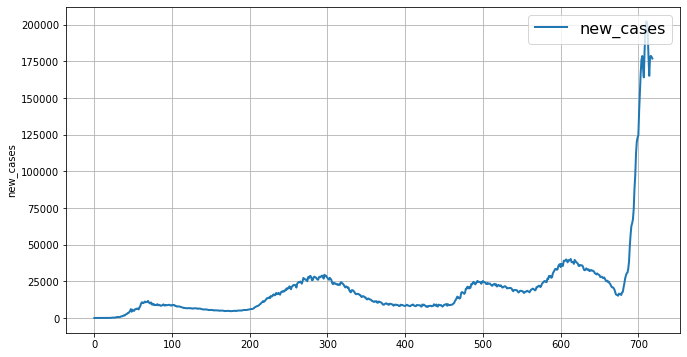

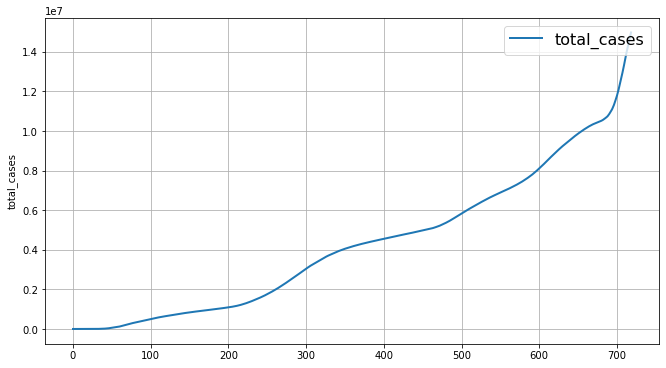

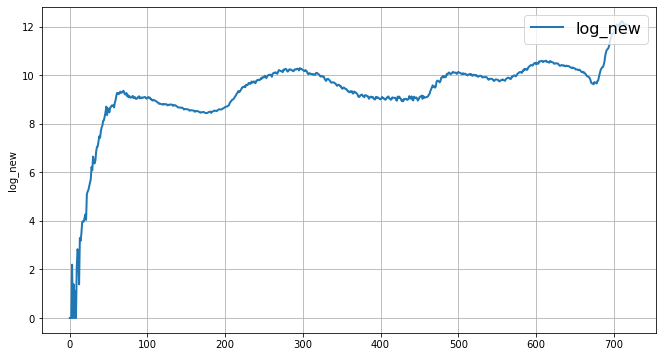

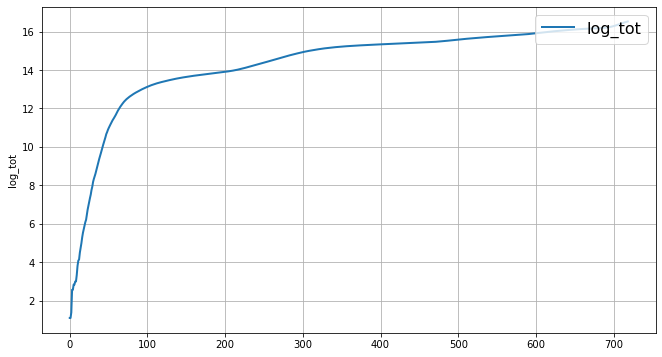

(<Figure size 792x432 with 1 Axes>, <AxesSubplot:ylabel='log_tot'>)

In [6]:
def plot(y, x=None):
    fig, ax = plt.subplots(figsize=figsize)
    if x is None:
        x = np.array(list(range(len(y))))
    label = ''
    if hasattr(y, 'name'):
        ax.set_ylabel(y.name)
        label = y.name
    ax.plot(x, y, linewidth=2, label=label)
    ax.legend(loc="upper right", ncol=2, fontsize=legend_fontsize)
    plt.grid(True)
    plt.show()
    return fig, ax

plot(rudf['new_cases'])
plot(rudf['total_cases'])
plot(rudf['log_new'])
plot(rudf['log_tot'])

# 2 Exponential model 

## 2.1 Model for new cases

In [7]:
target = 'new_cases'
# First 50 days for training
train_limit = 50
# Limit number of days for testing
test_limit = 100


rudf_train = rudf[:train_limit]
rudf_test = rudf[train_limit:test_limit]

In [8]:
rudf_train.head()

,total_cases,new_cases,day,log_new,log_tot,bias
0,3.0,1.0,0,0.000000,1.098612,1.0
1,3.0,1.0,1,0.000000,1.098612,1.0
2,4.0,1.0,2,0.000000,1.386294,1.0
3,13.0,9.0,3,2.197225,2.564949,1.0
4,13.0,1.0,4,0.000000,2.564949,1.0


Prior values for model parameters and data standard deviation:

In [9]:
mu_0 = np.array([0, 0]).reshape((2,1))
sigma_0 = 1
S0 = sigma_0 * np.eye((len(mu_0)))

sigma_d = 2.8
alpha = sigma_d**2 / sigma_0**2 
alpha

7.839999999999999

Build model for linear ridge regression:

In [10]:
model = linear_model.Ridge(alpha)
model = model.fit(rudf_train[['day', 'bias']], np.log(rudf_train[target]))
model.coef_

array([0.18582318, 0.        ])

Calculate predictions for train set:

In [11]:
train_pre = np.exp(rudf_train[['day', 'bias']].to_numpy() @ model.coef_)

Plot real values and model predictions for train set:

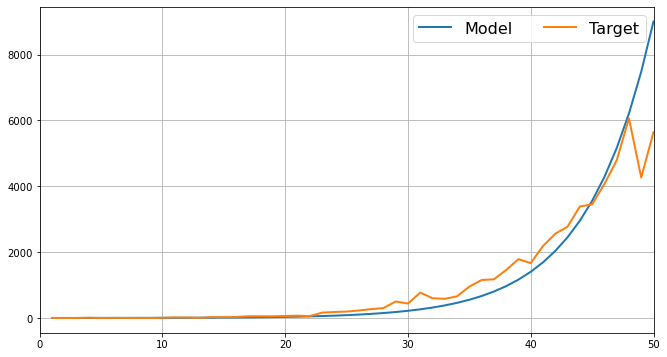

In [12]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
days = np.array(range(1, train_limit+1))
ax.plot(days, train_pre, linewidth=2, label='Model')
ax.plot(days, rudf_train[target], linewidth=2, label='Target')
ax.set_xlim((0, train_limit))

ax.legend(loc='upper right', ncol=2, fontsize=legend_fontsize)
plt.grid(True)
plt.show()

Plot for error of model:

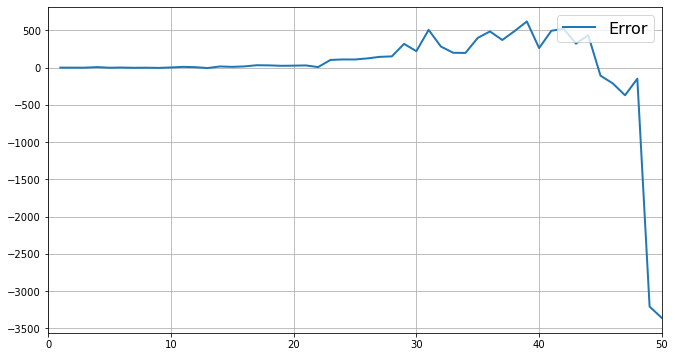

In [13]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
days = np.array(range(1, train_limit+1))
ax.plot(days, rudf_train[target][:train_limit] - train_pre[:train_limit], linewidth=2, label="Error")
ax.set_xlim((0, train_limit))
ax.legend(loc='upper right', ncol=2, fontsize=legend_fontsize)
plt.grid(True)
plt.show()

It can be seen that error is quite high and rises exponentialy in later days. Let's chhose first days for estimation of standard deviation of data:

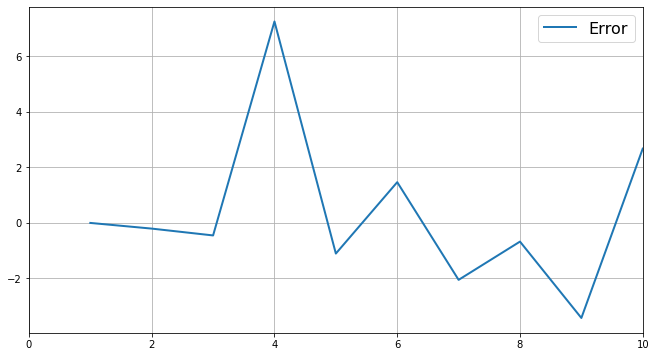

In [14]:
range_for_std = 10
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
days = np.array(range(1, range_for_std+1))
ax.plot(days, rudf_train[target][:range_for_std] - train_pre[:range_for_std], linewidth=2, label="Error")
ax.set_xlim((0, range_for_std))
ax.legend(loc='upper right', ncol=2, fontsize=legend_fontsize)
plt.grid(True)
plt.show()

Calculate standard deviation:

In [15]:
sigma_d = np.std( rudf_train[target][:range_for_std] - train_pre[:range_for_std])
print(f'Data std according to model is sigma_d = {sigma_d}')

Data std according to model is sigma_d = 2.8022655182850777


Prepare X and y variables for convinience usage in Bayesian update of model parameters

In [16]:
X = rudf_train[['day', 'bias']].to_numpy()
y = rudf_train[target].to_numpy().reshape((len(rudf_train[target]), 1))

Calculate updated Sn (posterior cavariance matrix):

In [17]:
Sn = np.linalg.inv(np.linalg.inv(S0) + (1 / sigma_d**2) * X.T @ X)
Sn

array([[ 0.00054178, -0.011472  ],
       [-0.011472  ,  0.37864939]])

Calculate posterior mu_n:

In [18]:
mu_n = Sn @ (np.linalg.inv(S0) @ mu_0 + (1 / sigma_d**2) * X.T @ y)
mu_n

array([[  76.63621476],
       [-710.67329174]])

Calculate predictions using posterior parameters of model and plot result:

In [19]:
predsB = np.exp(X @ mu_n)

C:\Users\rusebra\AppData\Local\Temp/ipykernel_32660/1507062575.py:1: RuntimeWarning: overflow encountered in exp
  predsB = np.exp(X @ mu_n)


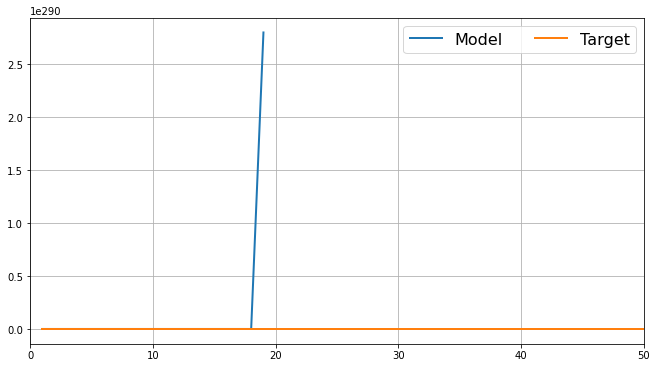

In [20]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
days = np.array(range(1, train_limit+1))
ax.plot(days, predsB, linewidth=2, label='Model')
ax.plot(days, rudf_train[target], linewidth=2, label='Target')
ax.set_xlim((0, train_limit))
ax.legend(loc='upper right', ncol=2, fontsize=legend_fontsize)
plt.grid(True)
plt.show()

The result is unsatisfying